<center>
<img src="warwick-logo.png">
<h1>Quantum Mechanics and Interatomic Potentials –<br> the QUIP code</h1>
<h3>James Kermode</h3>
Warwick Centre for Predictive Modelling / School of Engineering<br>
University of Warwick
<br>

<h4>CCP5++ Software Seminar - 17th June 2021</h4>    
    
    
<table bgcolor="#ffffff">   
<tr>
    <td><img src="WCPM_logo_text.png" width="100%"></td>
    <td><img src="hybrid.png" width="100%"></td>
</tr>
</table>

</center>


*These slides will subsequently be made available at <a href="https://libatoms.github.io/QUIP/Tutorials">https://libatoms.github.io/QUIP/Tutorials</a>*

In [ ]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import quippy
from mpl_toolkits.mplot3d import Axes3D

#Customize default plotting style
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

In [ ]:
plt.rcParams["figure.figsize"] = (12, 10)

from ase.neighborlist import neighbor_list

def get_bonds(atoms, cutoff=3.05, filter_in_cell=True):
    i, j, S = neighbor_list('ijS', atoms, cutoff)
    if filter_in_cell:
        in_cell = np.all(S == 0., axis=1)
        i = i[in_cell]
        j = j[in_cell]
    bonds = [ np.r_[[atoms.positions[I, :], 
                     atoms.positions[J, :]]] for (I, J) in zip(i, j)]
    return bonds

# Motivation

- Many of the activities our community is interested in require *robust*, *automated* coupling of two or more codes
- For example, current projects include:

    - developing and applying multiscale methods
    - generating interatomic potentials
    - uncertainty quantification

<center>
<img src="multiscale.png" width="80%">
</center>

*Image credit: Gábor Csányi*

# The QUIP code

[QUIP](https://libatoms.github.io/QUIP) is a collection of software tools to carry out molecular dynamics simulations in non-standard ways, in particular:

- Using the Gaussian Approximation Potential (GAP) framework for data-driven potentials

- Hybrid combinations in the style of QM/MM with a particular focus on materials systems such as metals and semiconductors

Long-term support of the package is ensured by:
   - James Kermode (Warwick)
   - Gabor Csanyi (Cambridge)
   - Noam Bernstein (Naval Research Lab)
   
**Portions of the code were written by:** Albert Bartok-Partay, Livia
Bartok-Partay, Federico Bianchini, Anke Butenuth, Marco Caccin,
Silvia Cereda, Gabor Csanyi, Alessio Comisso, Tom Daff, ST John,
Chiara Gattinoni, Gianpietro Moras, James Kermode, Letif Mones,
Alan Nichol, David Packwood, Lars Pastewka, Giovanni Peralta, Ivan
Solt, Oliver Strickson, Wojciech Szlachta, Csilla Varnai, Steven
Winfield, Tamas K Stenczel, Adam Fekete. 

See [GitHub contributors](https://github.com/libAtoms/QUIP/graphs/contributors) for a more complete list of code authors

# Code philosophy and goals

- QUIP was born because of the need to efficiently tie together a wide variety of different models, both empirical and quantum mechanical.

- It is not intended to be competitive in terms of performance with codes such as LAMMPS and Gromacs. 

- The Atomic Simulation Environment (ASE) also does does this, and is much more widely used, but QUIP has a number of unique features:

    - Access to Fortran types and routines from Python via the quippy package
    - Support for Gaussian Approximation Potentials (GAP)
    - Does not assume minimum image convention, so interatomic potentials can have cutoffs that are larger than the periodic unit cell size

## History

- QUIP began as rewrite of earlier C++ and Fortran 77 codes in ca. 2005
- Coded in modern Fortran (Fortran 95 plus allocatable array extensions, but none of the object-oriented features from 2003/2008, mostly because of limited compiler support historically)
- [Expressive Programming](http://www.southampton.ac.uk/~fangohr/randomnotes/iop_cpg_newsletter/2007_1.pdf), where code is as close as possible to abstract algorithm, without sacrificing (too much) performance
    - e.g. we have a `type(Atoms)` with components `Atoms%positions`, etc
    - not a full OO approach with arrays of individual `Atom` objects, which would risk reducing cache efficiency
- OpenMP and MPI parallelisation for potential evaluation (although LAMMPS `pair_style quip` will be faster)
- `quippy` deep Python bindings provided acccess to elements within derived types

## Current status

- QUIP now comprises ~200 kLOC of Fortran 95 code
- Main use is as GAP driver and for fitting GAP models
- Fortran to Python interface generation now separated out into [f90wrap](https://github.com/jameskermode/f90wrap) standalone package
- Code is now ~80% Fortran with minimal Python high-level interface to ASE
- Unit tests, driven via `quippy` Python package, have reasonable coverage of public API
- Continuous integration runs unit tests on GitHub Actions (recently migrated from Travis-CI) on all commits and before PRs get merged, and also builds [documentation](https://libatoms.github.io/QUIP)
- High-level generic functionality has (mostly) been moved out of QUIP and contributed to more widely used codes, e.g. the [preconditioned optimizers](https://wiki.fysik.dtu.dk/ase/ase/optimize.html#preconditioned-optimizers) in ASE were first prototyped in QUIP

# Code Availability

## License

Most of QUIP is licensed under the GPLv2, with some code in the public domain. Submodules have different licences, e.g. GAP has a non-commerical [academic software license](https://github.com/libAtoms/GAP/blob/main/LICENSE.md).

## Building from source

Quick start:
```
git clone --recursive https://github.com/libAtoms/QUIP
cd QUIP
export QUIP_ARCH=gfortran_linux_x86_64_openmp # for example
make config # answer some y/n questions
make
```

Required: 
   - recent `gfortran` or `ifort` compiler
   - LAPACK/BLAS linear algebra libraries (e.g. `libblas-dev` and `liblapack-dev` on Ubuntu or Intel MKL)
    
See the GitHub [README](https://github.com/libAtoms/QUIP) for detailed instructions, or try one of the pre-compiled binary releases.

## Binary Installation

I have very recently added binary wheels for Python on x86_64 Linux and Mac OS X machines:

```
pip install quippy-ase
```

Python dependencies (`numpy`, `f90wrap` and `ase`) are installed automatically, and you get the `quip` and `gap_fit` command line programs as a bonus. [Open issues](https://github.com/libAtoms/quippy-wheels/issues) in `quippy-wheels` with problems.

## Docker and Singularity containers

For a quick start, a pre-compiled [Docker image](https://hub.docker.com/r/libatomsquip/quip/) is also available:


```
docker pull libatomsquip/quip
```

This includes QUIP, GAP and LAMMPS setup to work with QUIP, and also works with Singularity for use on machines where you are not root:

```
singularity pull docker://libatomsquip/quip
```

# QUIP Features

The following interatomic potentials are presently coded or linked in QUIP:

 - BKS (van Beest, Kremer and van Santen) (silica)
 - EAM (fcc metals)
 - Fanourgakis-Xantheas (water)
 - Finnis-Sinclair (bcc metals)
 - Flikkema-Bromley
 - GAP (Gaussian Approximation Potentials)
 - Guggenheim-McGlashan
 - Brenner (carbon)
 - OpenKIM (general interface)
 - Lennard-Jones
 - ...
 

 - ...
 - MBD (many-body dispersion correction)
 - Morse
 - Partridge-Schwenke (water monomer)
 - Stillinger-Weber (carbon, silicon, germanium)
 - Si MEAM (silicon)
 - Sutton-Chen
 - Tangney-Scandolo (silica, titania etc) - including short-ranged reparamaterisation
 - Tersoff (silicon, carbon)
 - Tkatchenko-Sheffler pairwise dispersion correction

The following tight-binding functional forms and parametrisations are
implemented:

 - Bowler
 - DFTB
 - GSP
 - NRL-TB

# QUIP data model

Central to QUIP is the `Atoms` type.

Basic structure mirrors XYZ format with chemical species and atomic positions plus a free-form comment line.

Extended XYZ format adds lattice, PBC and additional columns:

```
2
Lattice="0.0 2.715 2.715 2.715 0.0 2.715 2.715 2.715 0.0" Properties=species:S:1:pos:R:3:forces:R:3 energy=-0.07221481569985196 pbc="T T T"
Si  0.00049671 -0.00013826  0.00064769 -0.00017116   0.00001541   0.00014705
Si  1.35902303  1.35726585  1.35726586  0.00017116  -0.00001541  -0.00014705
```

This maps onto QUIP's flexible (but not too flexible) data model for atomic per-configuration and per-atom properties, analogous to `ase.atoms.Atoms.arrays` and `ase.atoms.Atoms.info` dictionaries in ASE.

- Extended XYZ now quite widely used and supported, e.g. in [ASE](http://www.southampton.ac.uk/~fangohr/randomnotes/iop_cpg_newsletter/2007_1.pdf) and the [OVITO](https://www.ovito.org) visualisation package.

- Specification has recently been formalised to tidy up what's allowed in the `key=value` pairs. A canonical parser with C, Fortran, Python and Julia bindings will shortly be [released]( https://github.com/libAtoms/extxyz), and integration with all dependencies.

# Standalone QUIP usage

However you have installed QUIP, you will have a `quip` executable which can be used for basic tasks such as evaluating forces, energies and virials. For example, to use the Tangney-Scandolo potential to evaluate the energy of a quartz unit cell:

```shell
quip init_args="IP TS" param_filename=TS_params.xml atoms_filename=quartz.xyz E
```

Potential parameters are stored in XML files, and can be initialised either by name as above or by XML label, e.g.:

```shell
quip init_args="xml_label=TS_potential" param_filename=TS_params.xml atoms_filename=quartz.xyz E
```

The latter is more flexible as it supports potentials which are a combination of other potentials (e.g. a GAP with a 2-body and manybody contributions which must be summed to get the total potential).

There is also a built in MD code which has some specialised features, such as a Nose-Hoover-Langevin chain thermostat, but for general usage we recommend driving MD from either ASE or LAMMPS.

# Usage with LAMMPS

The LAMMPS MD code comes with a [USER-QUIP](https://docs.lammps.org/Build_extras.html#user-quip-package) package which can be turned out to provide a [pair_style quip](https://docs.lammps.org/pair_quip.html) command that allows QUIP potentials to be used within LAMMPS simulations.

For example, to use the Si GAP potential from LAMMPS, use a script simliar to [this one](quip_lammps_example.sh):

In [41]:
!cat quip_lammps_example.sh

#!/bin/bash

if [[ ! -f gp_iter6_sparse9k.xml ]]; then
    curl https://www.repository.cam.ac.uk/bitstream/handle/1810/317974/Si_PRX_GAP.zip -o Si_PRX_GAP.zip
    unzip Si_PRX_GAP.zip
fi

cat << EOF > lammps.in
units		metal
boundary	p p p

atom_style	atomic
atom_modify     map array sort 0 0.0

pair_style      quip
read_data       silicon_input_file.lmp
pair_coeff      * * gp_iter6_sparse9k.xml "Potential xml_label=GAP_2017_6_17_60_4_3_56_165" 14

neighbor	0.3 bin
neigh_modify	delay 10

fix		1 all nve
thermo		10
timestep	0.001

run		10
EOF

lmp_mpi < lammps.in


# Using QUIP with Python and the Atomic Simulation Environment

Python has emerged as the *de facto* standard “glue” language: codes that have a Python interface can be combined in complex ways

- [numpy](http://www.numpy.org/)/[scipy](http://scipy.org/) ecosystem
- [matplotlib](http://matplotlib.org/) plotting and interactive graphics
- [jupyter](https://jupyter.org/)/IPython notebooks encourage reproducible research
- [anaconda](https://jupyter.org/) distribution and package management system
   
<center><img src="scipy-stack.png" width="70%"></center>

http://www.scipy.org

# Atomic Simulation Environment (ASE)

- Within atomistic modelling, emerging standard for scripting interfaces is ASE
- Wide range of calculators, very similar data model for Atoms objects to QUIP
- Can use many codes as drop-in replacements:

<center><img src="ase-calculators.png" width="60%"></center>


https://wiki.fysik.dtu.dk/ase/

# `quippy` demo: analysing GAP models with predictive variance

As well as energy, force and virial stress, GAP potentials can be used to predict the uncertainty in the local energy due to limited training data by passing the `local_gap_variance` calculation argument, either when constructing the potential or for specific calls.

We can use this to understand when and where more training data is needed. Let's try it out near a vacancy. First we build a bulk cell and relax it to get the correct lattice constant:

In [42]:
from ase.build import bulk
from ase.constraints import ExpCellFilter
from ase.optimize.precon import PreconLBFGS
from quippy.potential import Potential

# construct a potential, usage is the same as `quip` command line
pot = Potential('xml_label=GAP_2017_6_17_60_4_3_56_165',
                param_filename='gp_iter6_sparse9k.xml',
                calc_args='local_gap_variance')

si = bulk('Si', cubic=True) # 8 atom cubic silicon cell
si.calc = pot # associated Atoms with GAP calculator

# relax the unit cell to get equilibrium lattice constant
ecf = ExpCellFilter(si)
opt = PreconLBFGS(ecf, precon=None) # too small for preconditioning
opt.run(fmax=1e-3) # optimize cell and positions (although positions won't change here)
a0 = np.diag(si.cell).mean()
e0 = si.get_potential_energy() / len(si) # ground state energy per atom®

PreconLBFGS:   0  14:26:21    -1305.407858       0.0000       0.0097
PreconLBFGS:   1  14:26:23    -1305.421024       0.0000       0.0003


Now we make a supercell, choose an atom near the centre and delete it:

In [43]:
si_vac = bulk('Si', a=a0, cubic=True) * 2
si_vac.calc = pot

# find an atom near the middle of the cell and delete it
vac_idx = ((si_vac.positions - np.diag(si_vac.cell) / 2.0) ** 2).sum(axis=1).argmin()
vac_pos = si_vac.positions[vac_idx]
del si_vac[vac_idx]

# displace atoms from equilibrium
si_vac.rattle(0.05)

local_energy = si_vac.get_potential_energies() - e0 # get the per-atom energies

# additional quantities returned by the Potential are stored in `extra_results` dictionary
local_sigma = np.sqrt(pot.extra_results['atoms']['local_gap_variance']) * 1e3 # convert to meV
local_sigma 

array([1.09028249, 1.06446493, 1.08042361, 1.09726393, 1.04964909,
       1.07696073, 1.04253642, 1.05756564, 1.07986555, 1.21075713,
       1.08904488, 1.06067924, 1.03184873, 1.0483741 , 1.50264259,
       8.82800571, 1.13526427, 1.07445902, 1.06308149, 1.05085032,
       1.36672006, 7.41051599, 1.07830702, 1.05714689, 1.07577689,
       1.11775393, 1.02777397, 1.03472811, 1.37581384, 1.07758179,
       1.40593821, 1.11762489, 1.02609731, 1.0472251 , 1.6245512 ,
       9.00662199, 1.07141401, 1.07419136, 1.04675406, 1.09336236,
       1.02187833, 1.09920161, 1.635866  , 1.07518514, 1.03719514,
       1.035885  , 1.60476878, 1.11706124, 1.03425407, 1.09399015,
       1.33701387, 1.06056646, 1.55086343, 1.16445632, 1.08280879,
       1.07055096, 8.81939969, 1.39563815, 1.07894506, 1.62557041,
       1.13917427, 1.38065722, 1.03189404])

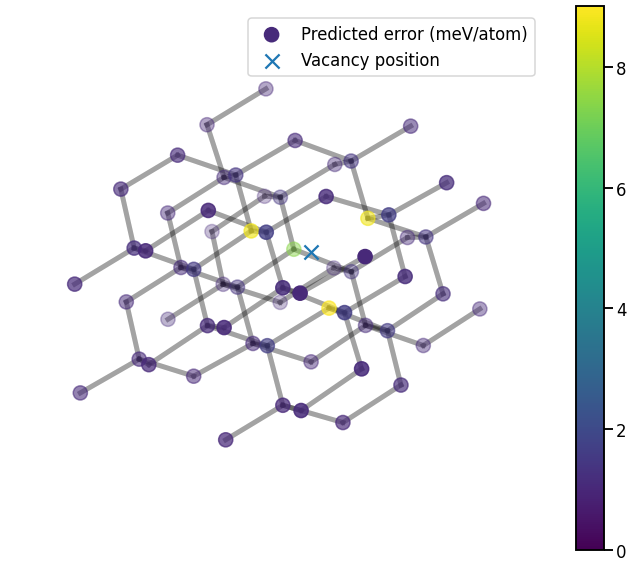

In [44]:
# plot predicted errors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for bond in get_bonds(si_vac):
    ax.plot(bond[:, 0], bond[:, 1], bond[:, 2], c='k', lw=5, alpha=0.2)

p = ax.scatter(si_vac.positions[:, 0], si_vac.positions[:, 1], si_vac.positions[:, 2],
               s=200, c=local_sigma, label='Predicted error (meV/atom)', vmin=0)
ax.scatter([vac_pos[0]], [vac_pos[1]], [vac_pos[2]], s=200, marker='x',
           label='Vacancy position')
fig.colorbar(p, ax=ax)
ax.legend()
ax.set_axis_off()          

Unsurprisingly, the predicted errors rise near the vacancy; even though vacancies are accurately predicted by this GAP model, they are still less well covered by the training database than bulk-like configurations.

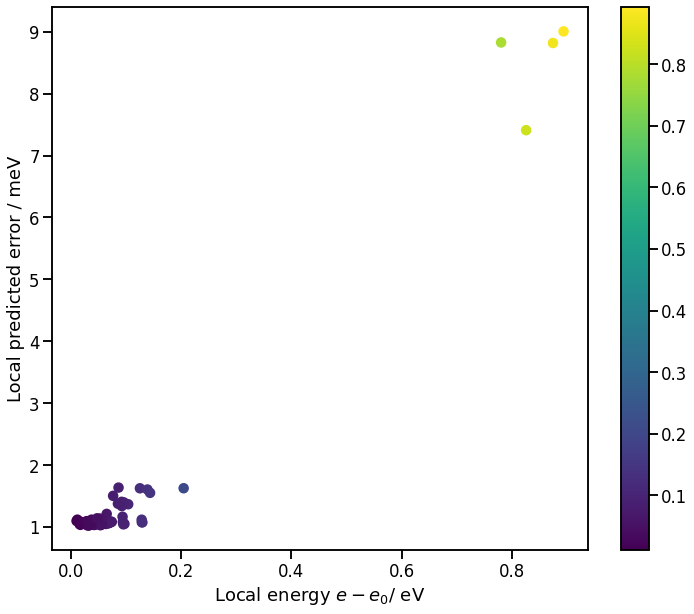

In [45]:
# plot local_energy vs local_sigma
fig, ax = plt.subplots()
p = ax.scatter(local_energy, local_sigma, c=local_energy)
fig.colorbar(p)
ax.set_xlabel('Local energy $e - e_0$/ eV')
ax.set_ylabel('Local predicted error / meV');

# Atomic Environment Descriptors

The descriptors used for training GAP models are also available through the `quippy` Python wrapper (and also through the `quip` command line tool, if you prefer). This is very useful for interactive analysis or for prototyping new approaches before implementing them in Fortran.

For example, to compare the atoms in our vacancy structure with one another and also with a very different structure (fcc), we can use the `Descriptor` wrapper class:

In [46]:
from quippy.descriptors import Descriptor

desc = Descriptor("soap l_max=6 n_max=12 cutoff=5.0 atom_sigma=0.5")

D1 = desc.calc(si_vac)['data']

si_fcc = bulk('Si', 'fcc', a=a0) * 3
si_fcc.rattle(0.05)
D2 = desc.calc(si_fcc)['data']

D = np.r_[D1, D2] # stack arrays in shape N_atoms x N_desc
labels = np.array([1] * len(si_vac) + [2] * len(si_fcc))
D.shape

(90, 547)

The kernel matrix can be computed from the descriptor arrays via

$$
K_{ij} = [(D D^T)]_{ij}^\zeta
$$

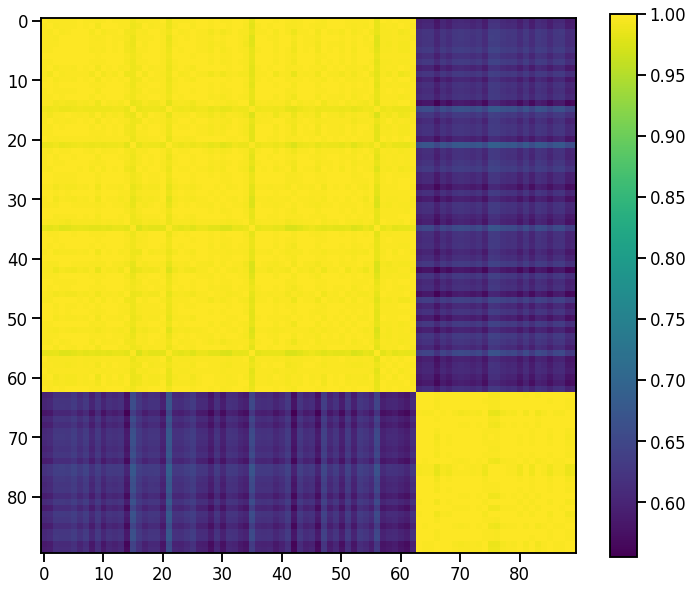

In [47]:
K = np.power(D @ D.T, 2.0) # exponent ζ=2
plt.imshow(K)
plt.colorbar();

# Kernel PCA

We can use this kernel matrix to map environments:

In [49]:
N = K.shape[0]; one_n = np.ones((N,N)) / N
K = K - one_n @ K - K @ one_n + one_n @ K @ one_n # centre K
eigvals, eigvecs = scipy.linalg.eigh(K)
eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1] # reverse order
X_pca = np.c_[[eigvecs[:, i] for i in range(2)]]   # select first 2 components

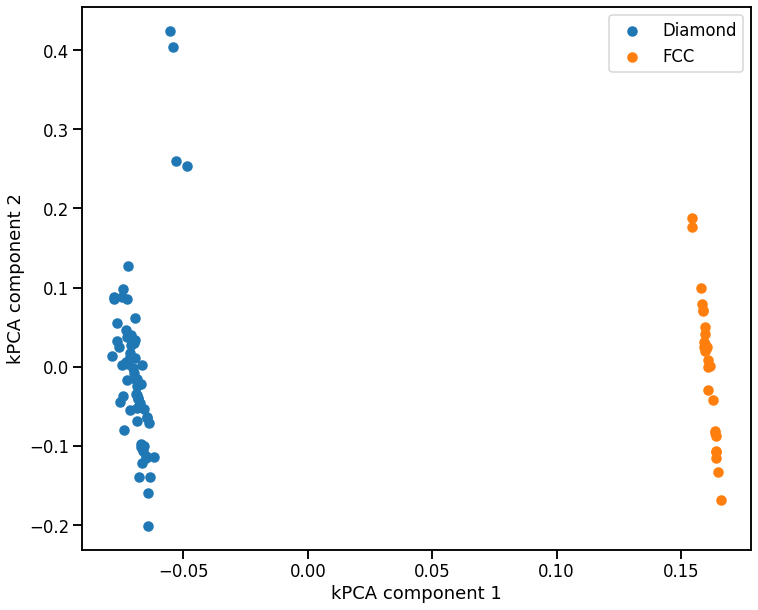

In [50]:
# plot kPCA map
fig, ax = plt.subplots()
ax.scatter(X_pca[0, labels == 1], X_pca[1, labels == 1], label='Diamond')
ax.scatter(X_pca[0, labels == 2], X_pca[1, labels == 2], label='FCC')
ax.set_xlabel('kPCA component 1')
ax.set_ylabel('kPCA component 2')
ax.legend();

If we zoom in just on the diamond configurations, and see that the kPCA also identifies the atoms near the vacancy as outliers

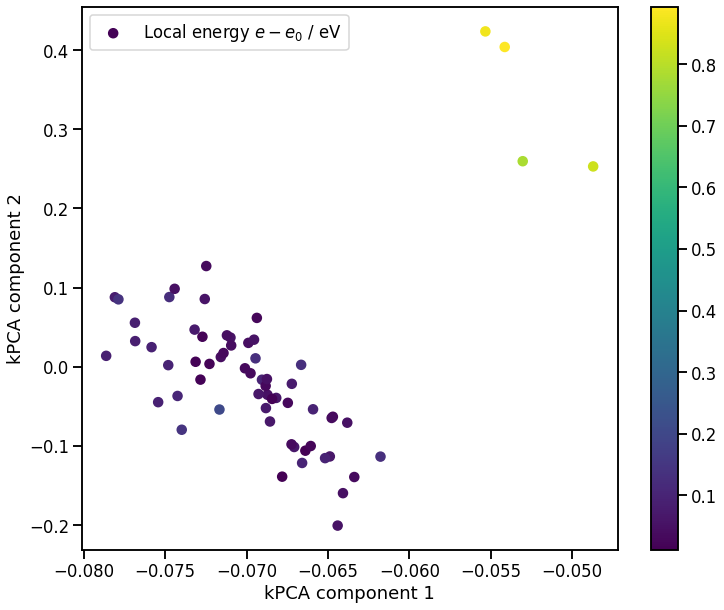

In [51]:
# plot zoomed in kPCA map
fig, ax = plt.subplots()
p = ax.scatter(X_pca[0, labels == 1], X_pca[1, labels == 1], c=local_energy, label='Local energy $e-e_0$ / eV')
ax.set_xlabel('kPCA component 1')
ax.set_ylabel('kPCA component 2')
ax.legend()
fig.colorbar(p);

# Deep wrapping demo: Tight Binding matrix elements

Sometimes it's useful to get interactive access to Fortran arrays, for example the tight binding Hamiltonian and Overlap matrices, either for post-processing, training other models or simply during debugging. The `f90wrap`-generated interface makes this possible, but it helps to have knowledge of the underlying Fortran code to know where to look.

Here we do this just at the $\Gamma$-point, but the complex-valued $H$ and $S$ at all $k-$points are also available (as are their derivatives, needed for computing forces).

In [53]:
tb_pot = Potential("TB DFTB k_density=0.03 use_k_density", param_filename="TB_params.xml")

# size of matrices is N_orb x N_atoms
N_orb = 4
N_atoms = len(si_vac)

# allocate memory from Python - note it is Fortran contigous 
H = np.zeros((N_orb * N_atoms, N_orb * N_atoms), order='F')
S = np.zeros((N_orb * N_atoms, N_orb * N_atoms), order='F')

tb_pot.get_potential_energy(si_vac) # trigger a calculation

# now we can poke around inside 
tb_pot._quip_potential.calc_tb_matrices(tb_pot._quip_atoms, hd=H, sd=S)

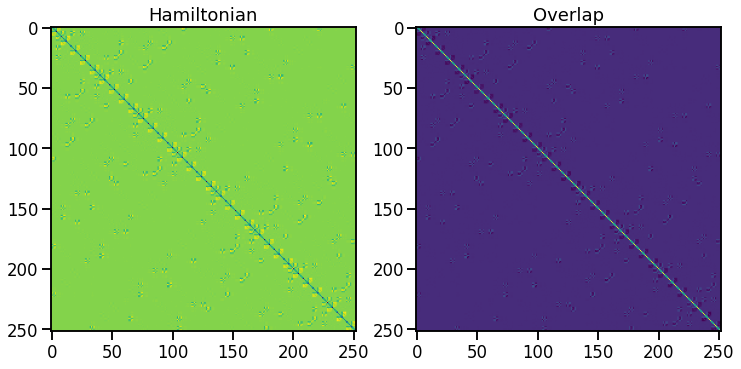

In [54]:
# visualise Hamiltonian and Overlap matrices
fig, axs = plt.subplots(1, 2)
for ax, mat, title in zip(axs, [H, S], ['Hamiltonian', 'Overlap']):
    p = ax.imshow(mat)
    ax.set_title(title);

## Post-processing example: density of states

Given $H$ and $S$, we can solve the eigenvalue problem $H \phi_i = \epsilon_i S \phi_i$ and plot the bandstructure or DoS

In [56]:
E_vac, phi = scipy.linalg.eigh(H, S)
E_F = tb_pot._quip_potential.simple.tb.fermi_e # extract Fermi energy from inside QUIP

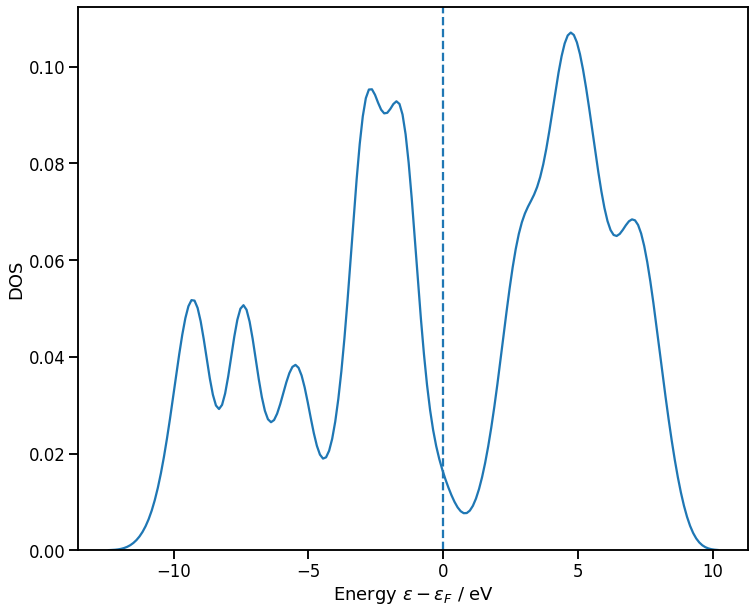

In [58]:
# Density of states plot
ax = sns.kdeplot(E_vac - E_F, bw_method=0.1, label='Vacancy')
ax.set_xlabel('Energy $\epsilon - \epsilon_F$ / eV');
ax.set_ylabel('DOS')
ax.axvline(0.0, linestyle='--');

# Integration with other Python packages

- [ASE](https://wiki.fysik.dtu.dk/ase/index.html) integration has already been discussed
- [ASR](https://asr.readthedocs.io/en/latest/) (Atomic Simulation Recipes) recently released workflow management tool
- [matscipy](https://github.com/libAtoms/matscipy), developed by James Kermode and Lars Pastewka, provides generic materials science tools, e.g. elastic constants, dislocation and fracture structure generation, as well as acting as a gateway for functionality which will later be contributed to ASE
- [testing-framework](https://github.com/libAtoms/testing-framework) is a generic testing framework for atomistic models, particularly relevant for data-driven/machine learning potentials. There's a Binderised [demo notebook](https://mybinder.org/v2/gh/libAtoms/testing-framework/public?filepath=examples%2Fdemo.ipynb) in its repo.
- [pymatnest](https://github.com/libAtoms/pymatnest) is a package for carrying out nested sampling to explore the energy landscape of materials. It has efficient interfaces to both QUIP and LAMMPS.

   
# Generalisation: `f90wrap` wraps other Fortran codes

<!-- <img src="f90wrap.png" align="left"> -->

- Writing deep Python interfaces 'by hand' is possible but tedious
- There are good automatic interface generators for C++ codes (e.g. SWIG or Boost.Python), but nothing support modern Fortran. 
- NumPy's `f2py` tool provides basic Fortran wrapping
- My [f90wrap](https://github.com/jameskermode/f90wrap) package adds  an additional layer of wrappers, giving support for derived types, module data, efficient array access
- As well as `quippy`, `f90wrap` provides a deep [Python interface](http://wrap.warwick.ac.uk/67696/2/18112256) to CASTEP (named `CasPyTep`) which allows in-place modification of data, efficient continuation of electronic calculations , etc.

J.R. Kermode, [*f90wrap: an automated tool for constructing deep Python interfaces to modern fortran codes*](https://iopscience.iop.org/article/10.1088/1361-648X/ab82d2), J. Phys.: Condens. Matter **32** 305901 (2020)